In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, accuracy_score, precision_score, recall_score, f1_score)
import joblib

In [2]:
# Load data
X_train = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\outputs\\X_train.csv')
X_test = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\outputs\\X_test.csv')
y_train = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\outputs\\y_train.csv').squeeze()
y_test = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\outputs\\y_test.csv').squeeze()

In [3]:
# Random Forest with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {
    'n_estimators': [100],              
    'max_depth': [10],                  
    'min_samples_split': [2, 5],        
    'min_samples_leaf': [1]             
}
rf_cv = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=StratifiedKFold(3), scoring='roc_auc', random_state=42)
rf_cv.fit(X_train, y_train)
best_rf = rf_cv.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [4]:
#XGBoost with Hyperparameter Tuning
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# Random Forest with Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100],              
    'max_depth': [3, 5],                
    'learning_rate': [0.1],             
    'subsample': [0.8],                
    'colsample_bytree': [0.8]           
}
xgb_cv = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=StratifiedKFold(3), scoring='roc_auc', random_state=42)
xgb_cv.fit(X_train, y_train)
best_xgb = xgb_cv.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:59:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:00:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:00:19] WARNING: C:\actions-runner\_work\xgbo

In [5]:
# Evaluation Function
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n📊 {name} Performance")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_true, y_proba):.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_true, y_proba):.2f})')



📊 Random Forest Performance
Confusion Matrix:
[[220453    599]
 [ 25032   5468]]
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95    221052
         1.0       0.90      0.18      0.30     30500

    accuracy                           0.90    251552
   macro avg       0.90      0.59      0.62    251552
weighted avg       0.90      0.90      0.87    251552

Accuracy:  0.8981
Precision: 0.9013
Recall:    0.1793
F1 Score:  0.2991
ROC AUC:   0.8870

📊 XGBoost Performance
Confusion Matrix:
[[219952   1100]
 [ 13620  16880]]
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    221052
         1.0       0.94      0.55      0.70     30500

    accuracy                           0.94    251552
   macro avg       0.94      0.77      0.83    251552
weighted avg       0.94      0.94      0.93    251552

Accuracy:  0.9415
Precision: 0.9388
Recall:    0.5534
F1 Score:  0.6964
ROC AUC:   0.9551


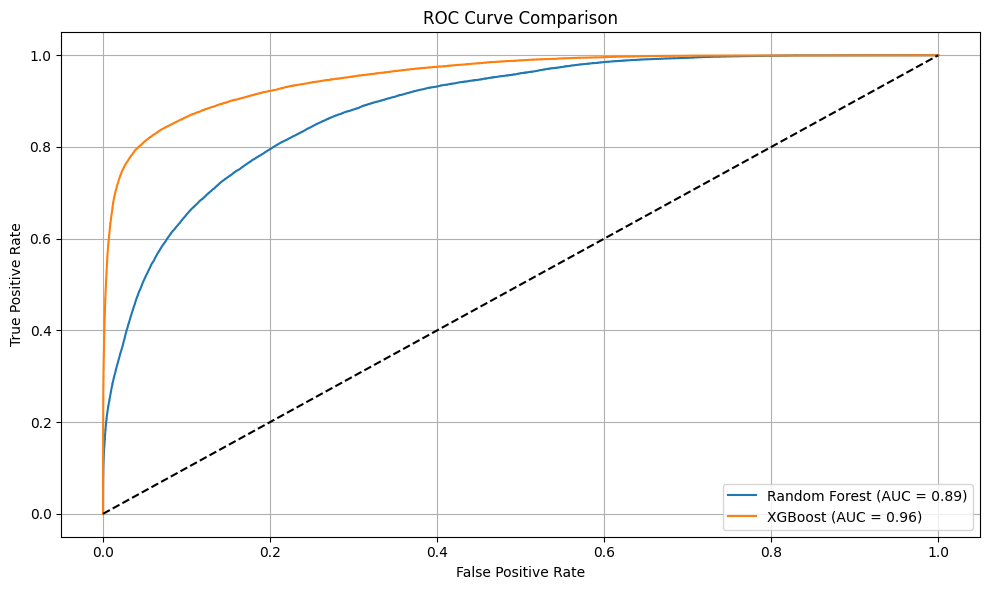

In [6]:
# Model Evaluations
plt.figure(figsize=(10, 6))
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Save Best Models
joblib.dump(best_rf, 'C:\\Users\\Admin\\asset_quality_score\\outputs\\best_random_forest.pkl')
joblib.dump(best_xgb, 'C:\\Users\\Admin\\asset_quality_score\\outputs\\best_xgboost.pkl')

['C:\\Users\\Admin\\asset_quality_score\\outputs\\best_xgboost.pkl']